In [4]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import geojson as gj
from tqdm import tqdm
import pickle
from shapely.geometry import Polygon
from shapely.geometry import Point
import shapely.speedups
import sys
shapely.speedups.enable()

import warnings
warnings.filterwarnings(action='ignore')

import json
import networkx as nx
from multiprocessing import Process
from pandas import ExcelWriter
import pydeck as pdk
from folium import FeatureGroup, LayerControl
import random
import plotly.express as px
import plotly
import plotly.graph_objects as go

In [5]:
import matplotlib as mpl# 기본 설정 만지는 용도
mpl.__version__ #matplotlib 3.6.1은 seaborn과 아직 충돌이 남.

'3.6.1'

In [2]:

import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
%matplotlib inline

## 1. 데이터 전처리

### 1.1. 그리드 통합 (3, 11, 12, 16, 17 번자료)

### 1.2. 분석에 필요한 데이터 프레임 생성
***

### 사용자 정의 함수 선언 
- write_data, load_data: pickle 라이브러리를 이용한 데이터 저장, 불러오기 함수
- split_18: 코드 정의서인 18번자료의 각 테이블을 개별 dataframe으로 잘라주는 함수
- get_data: 1~17번 자료를 한꺼번에 불러와 f_dict라는 딕셔너리에 저장
- grid_trim: 16번자료와 3~6번자료를 통합하는 함수, 사이즈가 다른 두 그리드를 500x500 사이즈로 변환함
    - 가나 : 한글 인덱스, 123: 숫자 인덱스, ab: 알파벳 인덱스
    
    - df1: 격자 개체의 크기가 100 x 100인 데이터 프레임, gid는 가나123456의 구조로 돼있으며 가는 '다'로 고정, 나는 '사' or '바'를 가짐 가, 나는 df2와 동일
    - 12는 가로축 고유 번호로 서쪽으로 갈 수록 값이 오르면 45는 세로축 번호로 남쪽으로 갈 수록 값이 오름. 3과 6은 0~9의 값을 가지며 서쪽, 남쪽으로 갈수록 큰 값을 가짐
    
    - df2: 격자 개체의 크기가 250 x 250인 데이터 프레임, gid는 가나12ab45cd의 구조로 돼있으며 가나, 12, 45는 df1과 같고 ab와 cd는 이진(a와 b로만 이루어짐) 인덱스로
    - ab는 가로 4개의 인덱스, cd는 세로 4개의 인덱스를 표현함. 즉 16개의 격자가 한 쌍으로 구성됨 (2진법의 네자리 경우의 수).
    
    - df1은 3~6번 데이터에 해당되며 df2는 16번 데이터임 df1의 격자 25개와 df2의 격자 16개가 겹치는 패턴을 보이기에 두 데이터 프레임을 합칠 수 있음
    
- assign_address: 11, 12번 자료를 사용해 주소 부여

In [3]:
def write_data(data, name):
    with open(name + '.bin', 'wb') as f:
        pickle.dump(data, f)
        
def load_data(name):
    try:
        with open(name + '.bin', 'rb') as f:
            data = pickle.load(f)
    except:
        with open(name + '.pickle', 'rb') as f:
            data = pickle.load(f)
    return data        
def split_18(df):
    code = pd.read_csv("18.코드정의서.csv", encoding = 'euc-kr')
    
    table_list = []
    start = 0
    for idx, value in code.iterrows():
        if value.isna()['col1'] :
            stop = idx
            cur_code = code.iloc[start:stop].rename(columns = {'col1':col1, 'col2':col2})
            cur_code = cur_code.reset_index(drop = True)
            try:
                cur_code.to_csv(cur_value + '.csv', index = False)
            except:
                cur_value = cur_value.replace('/', '')
                cur_code.to_csv(cur_value + '.csv', index = False)
            start = None
            continue
        elif value.isna()['col2']:
            cur_value = value['col1']
            start = idx + 2
            continue
        elif start - 1 == idx:
            col1, col2 = value['col1'], value['col2']
        else:
            continue
def code_search(code, scale = '중분류'):
    df = f_dict[2]
    if scale == '소분류':
        return df.loc[df['소분류코드'] == code]['소분류명'].to_list()[0]
    elif scale == '중분류':
        return df.loc[df['중분류코드'] == code]['중분류명'].to_list()[0]
    elif scale == '대분류':
        return df.loc[df['대분류코드'] == code]['대분류명'].to_list()[0]
def get_datas(path):
    os.chdir(path)
    files = os.listdir()
    f_dict = dict()
    
    for f in files:
        ext = f.split(sep = '.')[-1]
        num = f.split(sep = '.')[0]
        if num == 18:
            continue
        try:     
            if ext == 'csv':
                f_dict[int(num)] = pd.read_csv(f)
            elif ext == 'geojson':
                f_dict[int(num)] = gpd.read_file(f)
        except:
            continue
    os.chdir('../')
    return f_dict
def grid_trim(df_1, df1_dscrp, df_2, grid_size = 500):
    def get_bin_clss(code1, code2):
        def get_bin_num(code):
            if len(code) != 2:
                raise AssertionError('The length of string must be 2!')
            if code[0] == 'a' and code[1] == 'a':
                return 0
            elif code[0] == 'a' and code[1] == 'b':
                return 1
            elif code[0] == 'b' and code[1] == 'a':
                return 2
            elif code[0] == 'b' and code[1] == 'b':
                return 3
            else:
                raise AssertionError('The characters are has to be a or b!')
        code1 = get_bin_num(code1)
        code2 = get_bin_num(code2)
        if code1 < 2 and code2 < 2:
            return 0
        elif code1 < 2 and code2 > 1:
            return 1
        elif code1 > 1 and code2 < 2:
            return 2
        elif code1 > 1 and code2 > 1:
            return 3
    def get_digit_clss(num3, num6):
        num3 = int(num3)
        num6 = int(num6)
        if (num3 < 5 and num6 < 5):
            return 0
        elif (num3 < 5 and num6 > 4):
            return 1
        elif (num3 > 4 and num6 < 5):
            return 2
        elif (num3 > 4 and num6 > 4):
            return 3
    def get_digit_value(df):
        return str(get_digit_clss(df['3'], df['6']))
    def get_bin_value(df):
        return str(get_bin_clss(df['bin_1'], df['bin_2']))
    # dissolve df1
    df1 = gpd.GeoDataFrame(geometry = df_1.geometry)
    df1['GN1245'] = df_1.gid.str[0:4] + df_1.gid.str[5:7]
    df1['3'] = df_1.gid.str[4]
    df1['6'] = df_1.gid.str[7]
    df1['val'] = df_1.val
    
    if grid_size == 500:
        tile = df1.apply(get_digit_value, axis = 1)
        df1['GN1245T'] = df1.GN1245.str.cat(tile)
        df1 = df1.drop('GN1245', axis = 1)
        df1 = df1.drop('3', axis = 1)
        df1 = df1.drop('6', axis = 1)
        df1 = df1[['GN1245T', 'val', 'geometry']]
        df1_d = df1.dissolve(by = 'GN1245T', aggfunc = 'sum')
    else:    
        df1 = df1[['GN1245', '3', '6', 'val', 'geometry']]
        df1_d = df1.dissolve(by = 'GN1245', aggfunc = 'sum')
    df1_d.to_file(os.path.join(root_path, 'processed_data', df1_dscrp + '.csv'))
    
    # dissolve df2
    df2 = gpd.GeoDataFrame(geometry = df_2.geometry)
    df2['GN1245'] = df_2.gid.str[0:4] + df_2.gid.str[6:8]
    df2['bin_1'] = df_2.gid.str[4:6]
    df2['bin_2'] = df_2.gid.str[8:]
    cols = df_2.columns.to_list()
    cols.remove('gid')
    cols.remove('geometry')
    cols = cols + ['geometry']
    df2[cols] = df_2[cols]
    cols_ = ['GN1245', 'bin_1', 'bin_2'] + cols
    df2 = df2[cols_]
    
    if grid_size == 500:
        tile = df2.apply(get_bin_value, axis = 1)
        df2['GN1245T'] = df2.GN1245.str.cat(tile)
        df2 = df2.drop('GN1245', axis = 1)
        df2 = df2.drop('bin_1', axis = 1)
        df2 = df2.drop('bin_2', axis = 1)
        df2 = df2[['GN1245T'] + cols]
        df2_d = df2.dissolve(by = 'GN1245T', aggfunc = 'sum')
    else:
        df2_d = df2.dissolve(by = 'GN1245', aggfunc = 'sum')
    df2_d.to_file(os.path.join(root_path, 'processed_data', '16_소상공인_매출정보.csv'))
    
    df3 = gpd.GeoDataFrame(geometry = df1_d.geometry)
    df3[df1_dscrp] = df1_d['val']
    cols = df2_d.columns.to_list()
    df3[cols] = df2_d[cols]
    cols = [df1_dscrp] + cols + ['geometry']
    cols.remove('geometry')
    df3 = df3[cols]
    return df1_d, df2_d, df3, cols
def assign_address(f_dict, df_grid):
    df_grid.geometry = gpd.clip(df_grid.geometry, yongin)
    geo_c = df_grid.geometry.centroid
    gu_list = []
    emd_list = []
    missing_gu = []
    missing_emd = []
    for i in range(len(df_grid)):
        try:
            cur_item = f_dict[11].SIG_KOR_NM[gu.contains(geo_c.iloc[i])].item()
            gu_list.append(cur_item.split('시')[-1]) 
        except:
            gu_list.append(cur_item.split('시')[-1])
            missing_gu.append(i)
    for i in range(len(df_grid)):
        try:
            cur_item = f_dict[12].EMD_KOR_NM[emd.contains(geo_c.iloc[i])].item()
            emd_list.append(cur_item) 
        except:
            emd_list.append(cur_item)
            missing_emd.append(i)
    df_grid['GU'] = gu_list
    df_grid['EMD'] = emd_list
    return df_grid        

In [4]:
# 경로 설정
root_path = os.getcwd()
data_path = os.path.join(root_path, 'data')
pre_processed_path = os.path.join(root_path, 'processed_data')
result_path = os.path.join(root_path, 'results')
additional_path = os.path.join(root_path, 'additional_data')
dirs = [data_path, pre_processed_path, result_path, additional_path]
for i in dirs:
    if os.path.exists(i) == False:
        os.mkdir(i)

### 1.1. 그리드 통합 (3, 11, 12, 16, 17 번자료)

1. 16번 자료와 17번자료 통합
2. 총인구수 데이터 (3번 자료)와 수정된 16번 자료를 500x500의 크기로 합침
3. gid가 다사, 다바가 아닌 폴리곤 지우기
4. 11번자료 (시군구)와 12번 자료 (법정동)의 주소 정보를 통합 그리드 dataframe에 부여
5. 17번 자료에 16번 자료의 geometry자료와 11, 12번 자료의 주소 정보 부여

In [5]:
'''
저장된 전처리 데이터가 없으면 (첫 실행이라면) load를 False로 줘 
get_datas와 두 코드 통합 실행, 아니라면 True로 줘 미리 저장한 pickle 자료 불러오기
'''

# 전처리된 .bin 파일들을 불러오려면 load를 True로, 다시 처음부터 시작하려면 False로 설정
load = False 



if load == False:
    f_dict = get_datas(data_path)

    # 16번 자료와 17번 자료 통합
    new_df = pd.DataFrame(columns = f_dict[16].columns)
    gids = f_dict[17].gid.to_list()
    print('Merging dataframe 16 and 17...')
    for i in tqdm(range(len(f_dict[16]))):
        cur_gid = f_dict[16].iloc[i].gid
        if cur_gid in gids:
            new_df = new_df.append(f_dict[17].loc[f_dict[17].gid == cur_gid])
        else:
            new_df = new_df.append(f_dict[16].loc[f_dict[16].gid == cur_gid])
    
    new_df = new_df.reset_index(drop = True)    
    new_df['geometry'] = f_dict[16]['geometry']
    new_df = new_df.fillna(0)
    f_dict[16] = gpd.GeoDataFrame(new_df)
    
    # 총인구수 데이터 (3번 자료)와 수정된 16번 자료를 500x500의 크기로 합침
    df1, df2, df_grid, cols = grid_trim(f_dict[3], '총인구 수', f_dict[16], grid_size = 500)

    # 다사, 다바가 아닌 폴리곤 지우기
    to_remove = [i for i in df_grid.index if '다사' not in i and '다바' not in i]
    for i in to_remove:
        df_grid = df_grid.drop(i)
    gu = f_dict[11].geometry
    emd = f_dict[12].geometry
    yongin = Polygon(gu.geometry.unary_union.exterior)
    yongin = gpd.GeoDataFrame(geometry = [yongin])
    
    # 11번자료 (시군구)와 12번 자료 (법정동)의 주소 정보를 통합 그리드 dataframe에 부여
    df_grid = assign_address(f_dict, df_grid)
    f_dict['grid'] = df_grid
    
    # 17번 자료에 16번 자료의 geometry자료와 11, 12번 자료의 주소 정보 부여
    df_1 = f_dict[1]
    df_16 = f_dict[16]
    df_17 = f_dict[17] 
    df_16 = df_16.set_index('gid')
    df_17 = df_17.set_index('gid')
    df_17['geometry'] = df_16['geometry']
    df_17 = gpd.GeoDataFrame(df_17, geometry = 'geometry')
    df_17 = df_17.reset_index()
    f_dict['grid'] = df_grid
    # 1번 자료의 경위도 포인트를 17번 자료의 격자에 부여
    df_1 = df_1.dropna()
    
    # 경위도 정보로 포인트 생성
    def points_gen(df):
        return Point(df['경도'], df['위도'])
    df_1['geometry'] = df_1.apply(points_gen, axis = 1)
    df_1 = gpd.GeoDataFrame(df_1, geometry = 'geometry')
    df_1.crs = 'epsg:4326'
    
    # 각 그리드에 포인트 번호 부여
    contain_dict = dict()
    for i in tqdm(range(len(df_17))):
        cur_res =  df_1.loc[df_1.geometry.within(df_17.iloc[i]['geometry'])]
        if len(cur_res) != 0 :
            contain_dict[i] = cur_res.index.to_list()
        else:
            contain_dict[i] = None
    df_17['contains'] = list(contain_dict.values())
    
    # 각 그리드에 주소정보 부여
    df_17 = assign_address(f_dict, df_17)
    
    f_dict[17] = df_17
    os.chdir(pre_processed_path)
    write_data(f_dict, 'f_dict')
    os.chdir('../')
else:
    os.chdir(pre_processed_path)
    f_dict = load_data('f_dict')
    os.chdir('../')
    gu = f_dict[11].geometry
    emd = f_dict[12].geometry
    yongin = Polygon(gu.geometry.unary_union.exterior)
    yongin = gpd.GeoDataFrame(geometry = [yongin])
df_list = [str(i) for i in range(1, 18)]
for i in df_list:
        exec('df_{} = f_dict[int({})]'.format(i, i))
df_grid = f_dict['grid']

  0%|                                                                                | 12/9915 [00:00<03:04, 53.54it/s]

Merging dataframe 16 and 17...


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:14<00:00, 56.35it/s]


### 1.2. 분석에 필요한 데이터 생성

In [6]:
# 그리드 별 총 상점 수 구하기
if load == False:
    shop = f_dict[1]
    shop = gpd.GeoDataFrame(shop, geometry=gpd.points_from_xy(shop['경도'], shop['위도']))
    shop.set_crs(epsg = 4326, inplace = True)
    shop = shop.to_crs(epsg=4326)
    df_grid = f_dict['grid']

    f = lambda x:np.sum(shop.intersects(x))
    df_grid['총 상점 수'] = df_grid['geometry'].apply(f)
    
    os.chdir(pre_processed_path)
    write_data(df_grid, '총 상점 수')
    os.chdir('../')
else:
    shop = f_dict[1]
    shop = gpd.GeoDataFrame(shop, geometry=gpd.points_from_xy(shop['경도'], shop['위도']))
    shop.set_crs(epsg = 4326, inplace = True)
    shop = shop.to_crs(epsg=4326)
    os.chdir(pre_processed_path)
    df_grid = load_data('총 상점 수')
    os.chdir('../')
f_dict['grid'] = df_grid.reset_index()
df = f_dict['grid']
print(df)
shop

      GN1245T  총인구 수  ws_cnt  found_age_1  found_age_2  found_age_3  \
0     다바66990    0.0       0            0            0            0   
1     다바66991    0.0       0            0            0            0   
2     다바66992   88.0       0            0            0            0   
3     다바66993    0.0       0            0            0            0   
4     다바67983    0.0       0            0            0            0   
...       ...    ...     ...          ...          ...          ...   
2584  다사93040    0.0       0            0            0            0   
2585  다사93041    0.0       0            0            0            0   
2586  다사93050    0.0       0            0            0            0   
2587  다사93051    0.0       0            0            0            0   
2588  다사93052    0.0       0            0            0            0   

      found_age_4  found_age_5  found_age_6  runout_cnt  ...  age70_ratio  \
0               0            0            0           0  ...          

,대분류코드,중분류코드,소분류코드,표준산업분류코드,표준산업분류명,행정동코드,행정동명,도로명주소,경도,위도,geometry
0,Q,Q09,Q09A10,I56211,일반유흥 주점업,4146551000,풍덕천1동,경기도 용인시 수지구 풍덕천로139번길 6-5,127.096851,37.324611,POINT (127.09685 37.32461)
1,Q,Q01,Q01A08,I56111,한식 음식점업,4146551000,풍덕천1동,경기도 용인시 수지구 풍덕천로190번길 23,127.102347,37.324553,POINT (127.10235 37.32455)
2,Q,Q01,Q01A01,I56111,한식 음식점업,4146352000,구갈동,경기도 용인시 기흥구 갈곡로7번길 8,127.128573,37.272405,POINT (127.12857 37.27241)
3,Q,Q09,Q09A10,I56211,일반유흥 주점업,4146151000,중앙동,경기도 용인시 처인구 금령로71번길 2,127.204204,37.235371,POINT (127.20420 37.23537)
4,Q,Q10,Q10A01,I56111,한식 음식점업,4146359000,보정동,경기도 용인시 기흥구 죽전로 50,127.114245,37.320282,POINT (127.11424 37.32028)
...,...,...,...,...,...,...,...,...,...,...,...
39901,D,D24,D24A03,NaN,NaN,4146353500,보라동,경기도 용인시 기흥구 용구대로1890번길 16,127.105963,37.257377,POINT (127.10596 37.25738)
39902,L,L01,L01A01,L68221,부동산 자문 및 중개업,4146351500,NaN,경기도 용인시 기흥구 덕영대로 1981-1,127.098493,37.261763,POINT (127.09849 37.26176)
39903,Q,Q01,Q01A03,I56111,한식 음식점업,4146351000,신갈동,경기도 용인시 기흥구 신갈로58번길 8-1,127.106817,37.271945,POINT (127.10682 37.27195)
39904,Q,Q12,Q12A01,I56220,비알콜 음료점업,4146152000,역삼동,경기도 용인시 처인구 중부대로 1294,127.188290,37.235470,POINT (127.18829 37.23547)


In [7]:
# 업종 코드 대분류 테이블 생성
cols = df_2['대분류코드'].unique().tolist()
D_classified = pd.DataFrame(columns = cols).astype(np.int64)
for i, r in tqdm(df_17.iterrows()):
    if r.contains == None:
        D_classified = D_classified.append(pd.DataFrame(0, index = range(i, i + 1), columns = cols))
    else:
        cur_row = pd.DataFrame(0, index = range(i, i + 1), columns = cols)
        for n in r.contains:
            code = df_1.loc[n]['대분류코드']
            cur_row[code] += 1
    
        D_classified = D_classified.append(cur_row)

# 17번 테이블 열 변경
to_remove = [i for i in df_17.columns.tolist() if 'indcd_' in i]
df_17_mac = df_17.copy()
for c in to_remove:
    df_17_mac = df_17_mac.drop(c, axis = 1)
df_17_mac[cols] = D_classified
df_17_mac = df_17_mac[['gid', 'ws_cnt', 'smbiz_yn_cnt'] + cols + ['geometry']]

#  업종 코드 중분류 테이블 생성
cols = df_2['중분류코드'].unique().tolist()
J_classified = pd.DataFrame(columns = cols).astype(np.int64)
for i, r in tqdm(df_17.iterrows()):
    if r.contains == None:
        J_classified = J_classified.append(pd.DataFrame(0, index = range(i, i + 1), columns = cols))
    else:
        cur_row = pd.DataFrame(0, index = range(i, i + 1), columns = cols)
        for n in r.contains:
            code = df_1.loc[n]['중분류코드']
            cur_row[code] += 1
    
        J_classified = J_classified.append(cur_row)

# 17번 테이블 열 변경
to_remove = [i for i in df_17.columns.tolist() if 'indcd_' in i]
df_17_mid = df_17.copy()
for c in to_remove:
    df_17_mid = df_17_mid.drop(c, axis = 1)
df_17_mid[cols] = J_classified
df_17_mid = df_17_mid[['gid', 'ws_cnt', 'smbiz_yn_cnt'] + cols + ['geometry']]

807it [00:20, 38.61it/s] 
807it [00:20, 39.17it/s] 


## 2. 그리드 데이터를 활용한 분석 시행

### 2.1. 정규성 검사

### 2.2. 단순 분석

### 2.3. 핫스팟 분석

### 2.4. Average Nearest Neighbor 분석

### 2.5. 유동인구 분석

### 2.6. 연령대별 카드 사용 비율

***

In [8]:
import mapclassify as mc
import matplotlib.pyplot as plt
#import pysal.viz.mapclassify as mc
from matplotlib.colors import rgb2hex
from matplotlib.colors import ListedColormap
import matplotlib

In [9]:
root_path = os.getcwd()
if os.path.exists(os.path.join(root_path, 'results')) == False:
    os.mkdir(os.path.join(root_path, 'results'))
result_path = os.path.join(root_path, 'results')

### 2.1. 정규성 검사

In [10]:
import libpysal as lps
import esda
import pysal as ps
from numpy.random import seed
from numpy.random import randn
from scipy.stats import normaltest
from scipy.stats import shapiro
from scipy.stats import anderson

def normality_test(df, col) :
    print(col)
    
    print("D'Agostino and Pearson's Test")
    # D'Agostino and Pearson's Test
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import normaltest
    # seed the random number generator
    seed(1)

    # normality test
    stat, p = normaltest(df[col])
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    print()
    # interpret
    alpha = 0.05
    if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
    else:
            print('Sample does not look Gaussian (reject H0)')

    print()
    print()    
    
    #Shapiro-Wilk Test
    print("Shapiro-Wilk Test")
    from scipy.stats import shapiro
    from numpy.random import seed
    # seed the random number generator
    seed(1)
    # generate univariate observations

    # normality test
    stat, p = shapiro(df[col])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    print()
    # interpret
    alpha = 0.05
    if p > alpha:
            print('Sample looks Gaussian (fail to reject H0)')
    else:
            print('Sample does not look Gaussian (reject H0)')
            
    print()
    print()
    #Anderson-Darling Test
    
    print("Anderson-Darling Test")

    
    from numpy.random import seed
    from numpy.random import randn
    from scipy.stats import anderson
    # seed the random number generator
    seed(1)

    # normality test
    result = anderson(df[col])
    print('Statistic: %.3f' % result.statistic)
    p = 0.05
    for i in range(len(result.critical_values)):
            sl, cv = result.significance_level[i], result.critical_values[i]
            if result.statistic < result.critical_values[i]:
                    print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
            else:
                    print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

### 2.2. 단순 분석

#### 함수 정의

1. simple_grid_calc: 다양한 mode에 따라 간단한 column-wise 연산을 시행하고 반환하는 함수
    - col_name: 관심 column들이 공통적으로 가지고 있는 이름 (e.g., rpr_per_age_bin -> 추요 창업 연령대)
    - mode: sum, mean, weighted_mean, ratio 등 시행하고자 하는 연산 모드
    - basic_cols: 반환되는 데이터 프레임에 연산 결과와 함께 남기고 싶은 고유 key값들의 column 이름명, list여야 함
    - COI: 관심 column, 반환되는 데이터 프레임에 들어갈 연산 결과 column의 이름, 결과 이름은 mode와 함께 이루어짐
    - weight_dict: mode가 weighted_mean일 경우 각 column의 곱해줄 weight 값들을 가진 딕셔너리
    - col_name을 가지는 column들의 합산 결과가 이미있는 column이 있다면 그 column의 이름을 명시
    - div: 결과 column에 곱해주고 싶은 수(scalar)가 있다면 명시
2. plot_grid_map: 데이터 프레임 내 관심 컬럼 (COI)를 기준으로 분류하여 지도 생성, 저장
    - mode 값이 cont_classify라면 해당 column의 값이 연속변수이며 mc를 사용해 단계구분도를 그려주는 것
    - mode 값이 max_val 이나 categorical이라면 각 타일의 값에 따라 나눠 그려주는 것
    - nan 데이터는 No Data로 바꿔 회색(#bdbdbd)로 변경
    

In [15]:
def simple_grid_calc(col_name, df, mode = 'sum', basic_cols = ['GN1245T', 'GU', 'EMD'], COI = None, weight_dict = None, sum_col = None, div = None):
    
    i_cols = [i for i in df.columns.to_list() if col_name in i]
    if mode == 'weighted_mean':
        cols = basic_cols + [sum_col] + i_cols + ['geometry']
    else:
        cols = basic_cols + i_cols + ['geometry']
    tmp_df = df[cols]
    
    if mode == 'sum':
        col_result = col_name + '_sum'
        tmp_df[col_result] = tmp_df.sum(axis = 1)
    elif mode == 'mean':
        col_result = col_name + '_mean'
        tmp_df[col_result] = tmp_df.mean(axis = 1)
        if div:
            tmp_df[col_result] = tmp_df[col_result]/div
    elif mode == 'ratio':
        col_result = COI + '_ratio'
        tmp_df[col_result] = tmp_df[COI]/tmp_df.sum(axis = 1) * 100
    elif mode == 'max_val':
        col_result = 'max_val'
        tmp_df['sum'] = tmp_df[i_cols].sum(axis = 1)
        tmp_df[col_result] = tmp_df[i_cols].div(tmp_df['sum'], axis = 0).idxmax(axis = 1)
    elif mode == 'weighted_mean':
        for c in i_cols:
            tmp_df[c] = tmp_df[c] * weight_dict[c]
        col_result = col_name + '_weighted_mean'
        tmp_df[col_result] = tmp_df[i_cols].sum(axis = 1) / tmp_df[sum_col]
    if sum_col:
        cols = basic_cols + [sum_col] + i_cols + [col_result, 'geometry']
    else:
        cols = basic_cols + i_cols + [col_result, 'geometry']
    tmp_df = tmp_df[cols]
    return tmp_df
def plot_grid_map(df, f_name, col, k = 6, title = 'No name', mode = None, cls_dict = None, annotation = False, percen = True, colors = 'Blues', c_mode = 'NaturalBreaks'):
    
    # 폰트를 나눔고딕으로 설정 (mapplotlib 패키지 내 .font 필요)
    #matplotlib.rcParams['font.family'] = 'NanumGothic'
    
    if mode == 'cont_classify':
        if c_mode == 'NaturalBreaks':
            quantiles = mc.NaturalBreaks(df[col].dropna(), k = k)
        elif c_mode == 'FisherJenks':
            quantiles = mc.FisherJenks(df[col].dropna(), k = k)
        df['cls_value'] = quantiles.find_bin(df[col]).astype('str')
        df.loc[df[col].isnull(), 'cls_value'] = 'No Data'
        cmap = plt.cm.get_cmap(colors, k)
        cmap_list = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        if len(np.where(df['cls_value'].unique() == 'No Data')[0]) != 0:
            cmap_list.append('#bdbdbd')
        cmap_with_grey = ListedColormap(cmap_list)
    elif mode == 'max_val' or mode == 'categorical':
        df['cls_value'] = df[col]
        k = len(df['cls_value'].unique())
        df.loc[df[col].isnull(), 'cls_value'] = 'No Data'
        cmap = plt.cm.get_cmap(colors, k)
        cmap_list = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        if len(np.where(df['cls_value'].unique() == 'No Data')[0]) != 0:
            nan_idx = np.where(df['cls_value'].unique() == 'No Data')[0].item()
            cmap_list[nan_idx] = '#bdbdbd'
        cmap_with_grey = ListedColormap(cmap_list)
    
    # plot map
    fig, ax = plt.subplots(figsize=(12, 10))
    df.plot(column='cls_value', edgecolor='k', cmap=cmap_with_grey,
             legend=True, legend_kwds=dict(loc='upper right'),
             ax=ax)

    # annotate geometries
    if annotation == True:
        df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
        df['coords'] = [coords[0] for coords in df['coords']]
        for idx, row in df.iterrows():
            plt.text(x = row['coords'][0], y = row['coords'][1] , size=8, s=row['EMD'], ha="center", va="center")
    
    # change labels
    legend_labels = ax.get_legend().get_texts()
    if mode == 'cont_classify':
        # get all upper bounds in the quantiles category
        upper_bounds = quantiles.bins
        # get and format all bounds
        bounds = []
        for index, upper_bound in enumerate(upper_bounds):
            if index == 0:
                lower_bound = float(df.cls_value.min())
            else:
                lower_bound = float(upper_bounds[index-1])
            
            if percen == True:
                bound = '{}% - {}%'.format(round(lower_bound, 1), round(upper_bound, 1))
            else:
                bound = '{} - {}'.format(round(lower_bound, 2), round(upper_bound, 2))
            bounds.append(bound)
        
        # replace the numerical legend labels
        for bound, legend_label in zip(bounds, legend_labels):
            legend_label.set_text(bound)
    elif mode == 'max_val':
        for legend_label in legend_labels:
            legend_label.set_text(cls_dict[legend_label._text])
        
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    fig.show()
    fig.savefig(os.path.join(result_path, f_name), dpi=300)

In [12]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['C:\\WINDOWS\\Fonts\\BRADHITC.TTF',
 'C:\\Windows\\Fonts\\seguisbi.ttf',
 'C:\\Windows\\Fonts\\comici.ttf',
 'C:\\WINDOWS\\Fonts\\ANTQUAB.TTF',
 'C:\\WINDOWS\\Fonts\\msyhbd.ttc',
 'C:\\WINDOWS\\Fonts\\NanumMyeongjo.ttf',
 'C:\\Windows\\Fonts\\HANDotum.ttf',
 'C:\\Windows\\Fonts\\courbi.ttf',
 'C:\\Windows\\Fonts\\symbol.ttf',
 'C:\\WINDOWS\\Fonts\\BOD_BI.TTF',
 'C:\\Windows\\Fonts\\LBRITE.TTF',
 'C:\\WINDOWS\\Fonts\\BOOKOSBI.TTF',
 'C:\\WINDOWS\\Fonts\\BRLNSDB.TTF',
 'C:\\WINDOWS\\Fonts\\LeelawUI.ttf',
 'C:\\Windows\\Fonts\\segoeuib.ttf',
 'C:\\WINDOWS\\Fonts\\phagspab.ttf',
 'C:\\Windows\\Fonts\\georgia.ttf',
 'C:\\Windows\\Fonts\\BOD_R.TTF',
 'C:\\Windows\\Fonts\\DUBAI-LIGHT.TTF',
 'C:\\Windows\\Fonts\\H2MKPB.TTF',
 'C:\\WINDOWS\\Fonts\\LTYPEBO.TTF',
 'C:\\Windows\\Fonts\\LTYPEBO.TTF',
 'C:\\WINDOWS\\Fonts\\trebucbi.ttf',
 'C:\\WINDOWS\\Fonts\\LeelUIsl.ttf',
 'C:\\Windows\\Fonts\\KoPubWorld Batang Light.ttf',
 'C:\\Windows\\Fonts\\CHILLER.TTF',
 'C:\\Windows\\Fonts\\BRLNSB.TTF',
 'C

In [13]:
print (matplotlib.matplotlib_fname())

C:\Users\unhoc\Anaconda3\envs\gpd36\lib\site-packages\matplotlib\mpl-data\matplotlibrc


rpr_per_age_bin_20_ratio
1위: 역북동
2위: 운학동
3위: 상갈동
4위: 양지면
5위: 고매동


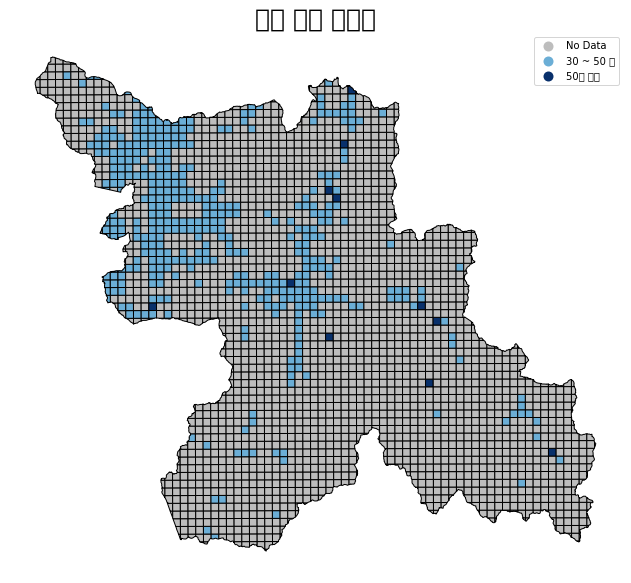

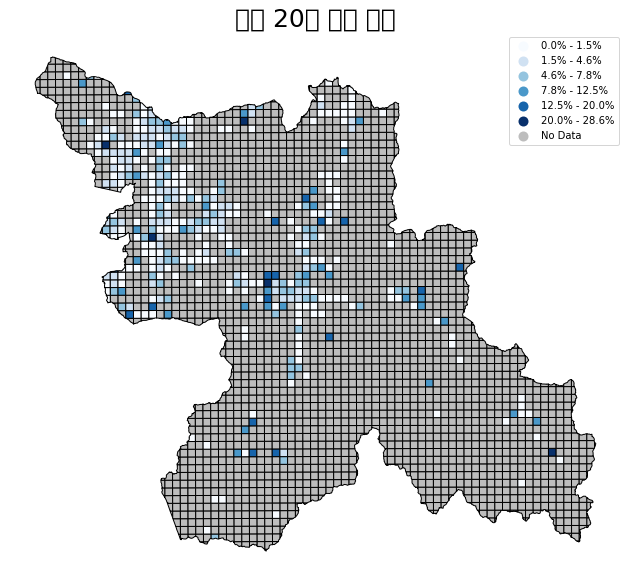

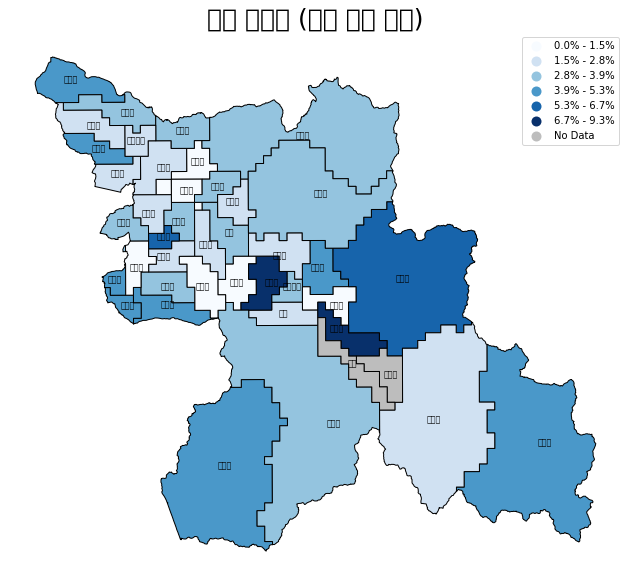

In [16]:

# 주요 창업 연령대
CsOI = 'rpr_per_age_bin'
mode = 'max_val'
COI = ''
df_ = simple_grid_calc(CsOI, df, mode = mode)
cls_dict = {'No Data': 'No Data',
            'rpr_per_age_bin_10': '10 대',
            'rpr_per_age_bin_20': '20 대',
            'rpr_per_age_bin_30to50': '30 ~ 50 대',
            'rpr_per_age_bin_50over' : '50대 이상'}

plot_grid_map(df_, '주요 창업 연령대_.png', col = mode, title = '주요 창업 연령대', mode = mode, cls_dict = cls_dict, colors = 'Blues')

# 20대 창업 비율

CsOI = 'rpr_per_age_bin'
mode = 'ratio'
COI = 'rpr_per_age_bin_20'
df_ = simple_grid_calc(CsOI, df, mode = mode, COI = COI)

plot_grid_map(df_, '창업 비율.png', col = COI + '_' + mode, title = '청년 20대 창업 비율', mode = 'cont_classify')

# 젊은 법정동

df_youth = df_.dissolve(by = 'EMD', as_index = False , aggfunc = 'mean')
plot_grid_map(df_youth, '젊은 법정동 (청년 창업 비율)_.png', col = COI + '_' + mode, title = '젊은 법정동 (청년 창업 비율)', mode = 'cont_classify', annotation = True)

# 20대 창업률이 높은 곳
print(COI + '_' + mode)
df_20_biz = df_youth.reset_index().sort_values(by = COI + '_' + mode, ascending = False)
#df_20_biz
for i in range(0, 5):
    print('{}위: {}'.format(i + 1, df_20_biz.iloc[i]['EMD']))

In [ ]:
# 평균 사업체 나이
age_dict = dict()
for i in range(1, 7):
    age_dict['found_age_' + str(i)] = i
df_ = df.copy()
df_['net_ws_cnt'] = df['ws_cnt'] - df['runout_cnt']
df_age = simple_grid_calc(col_name = 'found_age', df = df_, mode = 'weighted_mean', weight_dict = age_dict, sum_col = 'net_ws_cnt')
plot_grid_map(df_age, '평균 사업체 나이.png', col = 'found_age' + '_' + 'weighted_mean', title = '사업체 평균 나이', mode = 'cont_classify', colors = 'Reds', percen = False)

# 사업체 평균나이가 높은 곳
df_ages_emd = df_age.dissolve(by = 'EMD', as_index = False , aggfunc = 'mean')
df_ages_emd = df_ages_emd.reset_index().sort_values(by = 'found_age' + '_' + 'weighted_mean', ascending = False)
#df_20_biz
for i in range(0, 5):
    print('{}위: {}'.format(i + 1, df_ages_emd.iloc[i]['EMD']))

In [ ]:
# 총 인구 수 단계구분 plot
plot_grid_map(df, '총 인구 수.png', col = '총인구 수', title = '총 인구 수', mode = 'cont_classify', percen = False, colors = 'Greens', c_mode = 'FisherJenks')

In [ ]:
# 총 상점 수 단계구분 plot
plot_grid_map(df, '총 사업체 수.png', col = 'ws_cnt', title = '총 사업체 수', mode = 'cont_classify', percen = False, colors = 'Greens', c_mode = 'FisherJenks')

In [ ]:
# 법정동 별 인구대비 사업체 수
df_ws_popul = df.copy()
ws_popul = df['총인구 수'].div(df['ws_cnt'], axis = 0)
ws_popul[ws_popul == np.inf] = np.nan
df_ws_popul['ws_popul'] = ws_popul
df_ws_popul = df_ws_popul[['GN1245T', 'GU', 'EMD', 'ws_popul', 'geometry']]
df_ws_popul_mer = df_ws_popul.dissolve(by = 'EMD', as_index = False , aggfunc = 'mean')
plot_grid_map(df_ws_popul, '타일 별 사업체 당 인구 수.png', col = 'ws_popul', title = '타일 별 사업체 당 인구 수 (인구/사업체 수)', mode = 'cont_classify', annotation = False, percen = False, colors = 'Greens')
plot_grid_map(df_ws_popul_mer, '법정동 별 사업체 당 인구 수.png', col = 'ws_popul', title = '법정동 별 사업체 당 인구 수 (인구/사업체 수)', mode = 'cont_classify', annotation = True, percen = False, k = 4, colors = 'Greens')

# 사업체 평균나이가 높은 곳
df_ages_emd = df_ws_popul_mer.dissolve(by = 'EMD', as_index = False , aggfunc = 'mean')
df_ages_emd = df_ages_emd.reset_index().sort_values(by = 'ws_popul', ascending = False)
#df_20_biz
for i in range(0, 5):
    print('{}위: {}'.format(i + 1, df_ages_emd.iloc[i]['EMD']))
    
    
#df_ws_popul_mer.plot(figsize=(19, 19), cmap = 'tab20c', edgecolor = 'gainsboro')
#df_ws_popul_mer_gu = df_ws_popul.dissolve(by = 'GU', as_index = False , aggfunc = 'mean')
#df_ws_popul_mer_gu.plot(figsize=(19, 19), cmap = 'Set3', edgecolor = 'gainsboro')


In [ ]:
# 재무 안정도 산출

df_finance = f_dict[16]

# 대출액 평균 금액
loan_dict = {'sme_loan_y_1' : 2500, 'sme_loan_y_2':7500, 'sme_loan_y_3':15000, 'sme_loan_y_4':35000, 'sme_loan_y_5':75000, 'sme_loan_y_6':100000}
df_loan = simple_grid_calc(col_name = 'sme_loan_y', df = df, mode = 'weighted_mean', weight_dict = loan_dict, sum_col = 'ws_cnt')

# 매출액
df_sales = simple_grid_calc(col_name = 'sales_est_amt', df = df, mode = 'mean')
# 매출, 채무 비율 (sales-loan-ratio)
df_finance['LSR'] = df_loan['sme_loan_y' + '_weighted_mean']/(df_sales['sales_est_amt' + '_mean'] * 4)
# 비율이 20 이상인 값은 지움
df_finance['LSR'] = df_finance['LSR'].where(df_finance['LSR'] < 20, np.nan)
# 안전성 지수 = SLR/평균 사업체 나이
df_finance['stability_index'] = df_finance['LSR'] / df_age['found_age' + '_weighted_mean']
cols = ['GN1245T', 'GU', 'EMD', 'geometry']
for c in cols:
    df_finance[c] = df[c]

df_finance = df_finance[['GN1245T', 'GU', 'EMD', 'geometry', 'LSR', 'stability_index']]

plot_grid_map(df_finance, '채무 매출 비율.png', col = 'LSR', title = '채무/매출 비율 (LSR: Loan-Sales-Raito)', mode = 'cont_classify', annotation = False, percen = False, colors = 'YlOrRd')

plot_grid_map(df_finance, '재무 안정도.png', col = 'stability_index', title = '재무 안정도 (LSR/평균 사업체 나이)', mode = 'cont_classify', annotation = False, percen = False, colors = 'YlOrRd')

### 2.3. 핫스팟 분석

- local moran's I 통계방법을 사용하여 핫스팟 분석

- grid 별 총 인구수, 상점수 hotpost 탐지 

In [ ]:
# grid 별 총인구수에 대한 moran scatter plot
wq =  lps.weights.Queen.from_dataframe(df)
c = df['총인구 수']
c_lag = lps.weights.lag_spatial(wq, c)
clagq5 = mc.Quantiles(c_lag, k=5)
b, a = np.polyfit(c, c_lag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(c, c_lag, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(c.mean(), c_lag.min(), c_lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(c_lag.mean(), c.min(), c.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(c, a + b*c, 'r')
plt.title('총 인구 수 Moran Scatterplot')
plt.ylabel('Spatial Lag of # of count')
plt.xlabel('# of count')
plt.savefig(os.path.join(result_path, '총인구 수 Moran.png'))
plt.show()


In [ ]:
# 통계적 유의한 지역 추출
li = esda.Moran_Local(c, wq)
sig = 1 * (li.p_sim < 0.05)
# hotspot , coldspot 추출
hotspot = 1 * (sig * li.q==1) # H-H
coldspot = 2 * (sig * li.q==3) # L-L

spots = hotspot + coldspot 
spot_labels = [ '0 ns', '1 hot spot', '2 cold spot']
labels = [spot_labels[i] for i in spots]

df['총인구 hot_spot'] = spots

# hotspot을 빨강색, coldspot 파랑색으로 단계구분도 plot

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True,         k=2, cmap=hmap, linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('총 인구 Hot spot and Cold spot')
plt.savefig(os.path.join(result_path, '총 인구 Hot_spot_cold_spot.png'))
plt.show()


In [ ]:
# grid 별 총 상점수에 대한 moran scatter plot
wq =  lps.weights.Queen.from_dataframe(df)
c = df['총 상점 수']
c_lag = lps.weights.lag_spatial(wq, c)
clagq5 = mc.Quantiles(c_lag, k=5)
b, a = np.polyfit(c, c_lag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(c, c_lag, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(c.mean(), c_lag.min(), c_lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(c_lag.mean(), c.min(), c.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(c, a + b*c, 'r')
plt.title('총 상점 수 Moran Scatterplot')
plt.ylabel('Spatial Lag of # of count')
plt.xlabel('# of count')
plt.savefig(os.path.join(result_path, '총 상점 수 Moran.png'))
plt.show()

In [ ]:
# 통계적 유의한 지역 추출
li = esda.Moran_Local(c, wq)
sig = 1 * (li.p_sim < 0.05)
# hotspot , coldspot 추출
hotspot = 1 * (sig * li.q==1) # H-H
coldspot = 2 * (sig * li.q==3) # L-L

spots = hotspot + coldspot 
df['상점 hot_spot'] = spots
spot_labels = [ '0 ns', '1 hot spot', '2 cold spot']
labels = [spot_labels[i] for i in spots]

# hotspot을 빨강 , coldspot 파랑으로 단계구분도 plot

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True,         k=2, cmap=hmap, linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('총 상점 Hot spot and Cold spot')
plt.savefig(os.path.join(result_path, '총 상점 Hot_spot_cold_spot.png'))
plt.show()

### 2.4. 최근린 (Average Nearest Neighbor) 분석

- grid 별 상점들의 최근접 이웃과의 거리의 평균 분석을 통해 상점간의 물리적 경쟁을 정량화해서 확인

In [ ]:
#!pip install pointpats
from pointpats.distance_statistics import G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv
from pointpats import PointPattern, PoissonPointProcess, as_window

In [ ]:
#df = f_dict['grid']
df = df.reset_index()
# shop의 좌표계를 UTM-K로 변환
shop = shop.to_crs(epsg = 5179)
# 각 상점 별 최근접 이웃간의 거리 구하기(nearest neighborhodd distance: NND)
pp = PointPattern([(j.x,j.y) for j in shop['geometry']])
shop['nnd'] = pp.nnd
shop = shop.to_crs(epsg = 4326)

# 각 상점이 어느 grid에 속한지 확인
if load == False:
    gid = []
    for i in tqdm(range(len(shop))):
        if any(df['geometry'].contains(shop.iloc[i]['geometry'])):
            gid.append(df[df['geometry'].contains(shop.iloc[i]['geometry'])]['GN1245T'].values[0])
        else:
            gid.append('Null')
    
    os.chdir(pre_processed_path)
    write_data(gid, 'gid_ann')
    os.chdir('../')
else:
    os.chdir(pre_processed_path)
    gid = load_data('gid_ann')
    os.chdir('../')
shop['gid'] = gid

In [ ]:
# 각 grid 별 평균 nnd 구하기

gid_list = set(shop['gid'])
max_nnd = 0 
d= dict()
for i in gid_list:
    temp = shop[shop['gid']==i]
    mean_nnd = temp['nnd'].sum()/len(temp)
    d[i] = mean_nnd
    print(i,': 평균 nn 거리',mean_nnd)

 * ANN 값이 작을 수록 경쟁이 치열하다는 뜻이다
 * ANN 값을 역수로 취해줌으로서 경쟁이 치열한 정도를 눈으로 비교할 수 있음

In [ ]:
df.head()

In [ ]:
d.keys()

In [ ]:
# 평균 nnd컬럼을 생성하지 않으면, 에러가 됨. 버전 차이에 기인하는 것으로 생각됨.(20210419 21:21)
df['평균 nnd 역수'] = 0
# grid 별 ANN 역수 취하기
for i in df['GN1245T']:
    if i in d.keys():
        df.loc[df[df['GN1245T']==i].index,['평균 nnd 역수']] = 1/(d[i]+1)
    else:
        df.loc[df[df['GN1245T']==i].index,['평균 nnd 역수']]  = 0

In [ ]:
# ANN 역수를 HeadTailBreaks 방법으로 class를 나눈 후 단계구분도를 plot
hr10 = mc.HeadTailBreaks(df['평균 nnd 역수'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=hr10.yb,).plot(column='cl', categorical=True,         k=10, cmap='OrRd', linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Inverse of Average nearest neighbor distance (Head-Tail breaks)") # 색이 진할 수록 평균거리가 작음
plt.savefig(os.path.join(result_path, "Average nearest neighbor distance, Head-Tail breaks.png"))

### 2.5. 유동인구 분석

- 유동인구의 효율적인 분석을 위해 시간을 집계해 0-6시 사이를 새벽, 7-12시 사이를 아침, 13시-18시를 오후, 19시-24시를 저녁시간으로 나눔
- grid 별 새벽, 아침, 오후, 저녁시간의 유동인구를 단계구분도로 시각화하고 local moran's I로 핫스팟 탐지

In [ ]:
fp = f_dict[7]
fp['새벽 평균'] = fp.iloc[:,1:7].mean(axis=1)
fp['아침 평균'] = fp.iloc[:,7:13].mean(axis=1)
fp['오후 평균'] = fp.iloc[:,13:19].mean(axis=1)
fp['저녁 평균'] = fp.iloc[:,19:25].mean(axis=1)

In [ ]:
month = fp.groupby(['lat','lon'])['새벽 평균','아침 평균','오후 평균','저녁 평균'].agg('mean')
month = month.reset_index()
fp_g = gpd.GeoDataFrame(month, geometry=gpd.points_from_xy(month['lon'], month['lat']))
fp_g.set_crs(epsg = 4326, inplace = True)
# grid 별 유동인구 집계

        
if load == False:
    gid = []
    for i in tqdm(range(len(fp_g))):
        if any(df['geometry'].contains(fp_g.iloc[i]['geometry'])):
            gid.append(df[df['geometry'].contains(fp_g.iloc[i]['geometry'])]['GN1245T'].values[0])
        else:
            gid.append('Null')
            
    os.chdir(pre_processed_path)
    write_data(gid, 'gid_fp')
    os.chdir('../')
else:
    os.chdir(pre_processed_path)
    gid = load_data('gid_fp')
    os.chdir('../')

In [ ]:
fp_g['gid'] = gid
gid_list = set(fp_g['gid'])
d= dict()
for i in gid_list:
    temp = fp_g[fp_g['gid']==i]
    test = temp.iloc[:,2:6]
    mean_fp = test.mean(axis=0)
    d[i] = mean_fp

In [ ]:
# 먼저 컬럼을 만들고 대입을 해주어야 하는 것으로 방침이 변경된 모양임.
df['새벽 평균'] = 0
df['아침 평균'] = 0
df['점심 평균'] = 0
df['저녁 평균'] = 0

# 각grid 별 새벽, 아침, 점심, 저녁 평균 유동인구 계산
for i in tqdm(df['GN1245T']):
    if i in d.keys():
        df.loc[df[df['GN1245T']==i].index,['새벽 평균']] = d[i][0]
        df.loc[df[df['GN1245T']==i].index,['아침 평균']] = d[i][1]
        df.loc[df[df['GN1245T']==i].index,['점심 평균']] = d[i][2]
        df.loc[df[df['GN1245T']==i].index,['저녁 평균']] = d[i][3]
    else:
        df.loc[df[df['GN1245T']==i].index,['새벽 평균']] = 0
        df.loc[df[df['GN1245T']==i].index,['아침 평균']] = 0
        df.loc[df[df['GN1245T']==i].index,['점심 평균']] = 0
        df.loc[df[df['GN1245T']==i].index,['저녁 평균']] = 0
df['평균 유동인구'] = df['새벽 평균'] + df['아침 평균'] + df['점심 평균'] + df['저녁 평균']

In [ ]:
li = esda.Moran_Local(c, wq)
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1) # H-H
coldspot = 2 * (sig * li.q==3) # L-L

spots = hotspot + coldspot 
df['점심 hot_spot'] = spots
spot_labels = [ '0 ns', '1 hot spot', '2 cold spot']
labels = [spot_labels[i] for i in spots]

In [ ]:
def ydpop_plot(time = '아침'):
    # 점심 평균에 대한 moran scatter plot
    wq =  lps.weights.Queen.from_dataframe(df)
    c = df[time + ' 평균']
    c_lag = lps.weights.lag_spatial(wq, c)
    clagq5 = mc.Quantiles(c_lag, k=5)
    b, a = np.polyfit(c, c_lag, 1)
    f, ax = plt.subplots(1, figsize=(9, 9))

    plt.plot(c, c_lag, '.', color='firebrick')


     # dashed vert at mean of the price
    plt.vlines(c.mean(), c_lag.min(), c_lag.max(), linestyle='--')
     # dashed horizontal at mean of lagged price
    plt.hlines(c_lag.mean(), c.min(), c.max(), linestyle='--')

    # red line of best fit using global I as slope
    plt.plot(c, a + b*c, 'r')
    plt.title(time + ' 유동인구 Moran Scatterplot')
    plt.ylabel('Spatial Lag of # of count')
    plt.xlabel('# of count')
    plt.show()
    plt.savefig(os.path.join(result_path, time + ' 유동인구 Moran Scatterplot'))

    li = esda.Moran_Local(c, wq)
    sig = 1 * (li.p_sim < 0.05)
    hotspot = 1 * (sig * li.q==1) # H-H
    coldspot = 2 * (sig * li.q==3) # L-L

    spots = hotspot + coldspot 
    df[time + ' hot_spot'] = spots
    spot_labels = [ '0 ns', '1 hot spot', '2 cold spot']
    labels = [spot_labels[i] for i in spots]

    from matplotlib import colors
    # hotspot을 빨강 , coldspot 파랑으로 단계구분도 plot
    hmap = colors.ListedColormap(['lightgrey','red','blue'])
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=labels).plot(column='cl', categorical=True,         k=2, cmap=hmap, linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.title(time + ' 유동인구 Hotspot and Coldspot')
    plt.savefig(os.path.join(result_path, time + ' 유동인구 hotspot coldspot.png'))
    plt.show()

    # 점심 유동인구를 Quantiles 방법으로 class를 나눈 후 단계구분도를 plot
    hr10 = mc.Quantiles(df[time + ' 평균'], k=10)
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=hr10.yb,).plot(column='cl', categorical=True,         k=10, cmap='OrRd', linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.title(time + " 유동인구 Quantiles")
    plt.savefig(os.path.join(result_path, time + ' 유동인구 Quantiles.png'))
    # mc.HeadTailBreaks(df[time + ' 평균']).plot(df)

    # 점심 유동인구를 Natural Breaks 방법으로 class를 나눈 후 단계구분도를 plot
    exec('hr10 = mc.NaturalBreaks(df[\'' + time + ' 평균\'], k=10)')
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=hr10.yb,).plot(column='cl', categorical=True,         k=10, cmap='OrRd', linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.title(time + " 유동인구 NaturalBreaks")
    plt.savefig(os.path.join(result_path, time + ' 유동인구 NaturalBreaks.png'))

    # 점심 유동인구를 Fisher Jenks 방법으로 class를 나눈 후 단계구분도를 plot
    hr10 = mc.FisherJenks(df[time + ' 평균'], k=10)
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=hr10.yb,).plot(column='cl', categorical=True,         k=10, cmap='OrRd', linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.title(time + " 유동인구 Fisher Jenks")
    plt.savefig(os.path.join(result_path, time + ' 유동인구 Fisher Jenks.png'))

    # 점심 유동인구를 Head Tail Breaks 방법으로 class를 나눈 후 단계구분도를 plot
    hr10 = mc.HeadTailBreaks(df[time + ' 평균'])
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=hr10.yb,).plot(column='cl', categorical=True,         k=10, cmap='OrRd', linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
    ax.set_axis_off()
    plt.title(time + " 유동인구 Head Tail")
    plt.savefig(os.path.join(result_path, time + ' 유동인구 Head Tail.png'))

In [ ]:
ydpop_plot('새벽')
ydpop_plot('아침')
ydpop_plot('점심')
ydpop_plot('저녁')

### 2.6. 연령대별 카드 사용 비율

In [ ]:
# 외부자료 가져오기 (출처: 통계청)
df_kosis = pd.read_csv(os.path.join(additional_path,'가구주_연령별_가구당_월평균_가계지출__전국_1인이상__20210125151910.csv'), encoding='cp949')
df_kosis_39 = pd.DataFrame(columns = df_kosis.columns)
df_kosis_49 = pd.DataFrame(columns = df_kosis.columns)
df_kosis_59 = pd.DataFrame(columns = df_kosis.columns) 
df_kosis_60 = pd.DataFrame(columns = df_kosis.columns)

for idx, row in df_kosis.iterrows():
    if '39세' in df_kosis.iloc[idx]['가구주연령별(1)']:
        if '.' in df_kosis.iloc[idx]['가계지출항목별(1)']:
            df_kosis_39 = df_kosis_39.append(row)
    
    if '40' in df_kosis.iloc[idx]['가구주연령별(1)']:
        if '.' in df_kosis.iloc[idx]['가계지출항목별(1)']:
            df_kosis_49 = df_kosis_49.append(row)
    
    if '50' in df_kosis.iloc[idx]['가구주연령별(1)']:
        if '.' in df_kosis.iloc[idx]['가계지출항목별(1)']:
            df_kosis_59 = df_kosis_59.append(row)
        
    if '60세' in df_kosis.iloc[idx]['가구주연령별(1)']:
        if '.' in df_kosis.iloc[idx]['가계지출항목별(1)']:
            df_kosis_60 = df_kosis_60.append(row)

In [ ]:
def make_pie(df, title):
    fig = px.pie(df, values='2018', names='가계지출항목별(1)', title=title,
                 color= '가계지출항목별(1)',
                 color_discrete_map={'01.식료품 · 비주류음료 (원)': '#FD3216',
                                     '02.주류 · 담배 (원)': '#00FE35', 
                                     '03.의류 · 신발 (원)': '#6A76FC',
                                     '04.주거 · 수도 · 광열 (원)': '#FE00CE',
                                     '05.가정용품 · 가사서비스 (원)': '#0DF9FF',
                                     '06.보건 (원)': '#F6F926',
                                     '07.교통 (원)': '#FF9616', 
                                     '08.통신 (원)': '#479B55', 
                                     '09.오락 · 문화 (원)': '#D626FF', 
                                     '10.교육 (원)': '#86CE00',
                                     '11.음식 · 숙박 (원)': '#22FFA7', 
                                     '12.기타상품 · 서비스 (원)': '#E3EE9E'},
                 hover_data=['가계지출항목별(1)', '2018'])
    #fig.write_image(os.path.join(result_path, '{}.png'.format(title)))
    fig.show()
        
    
make_pie(df_kosis_39, '39세 이하 가구주의 월평균 가계지출 항목별 비율')
make_pie(df_kosis_49, '40~49세 이하 가구주의 월평균 가계지출 항목별 비율')
make_pie(df_kosis_59, '50~59세 이하 가구주의 월평균 가계지출 항목별 비율')
make_pie(df_kosis_60, '60세 이상 가구주의 월평균 가계지출 항목별 비율') 

In [ ]:
df17 = df_17.set_index('gid')
df17 = gpd.GeoDataFrame(df17, geometry = 'geometry')
df17 = df17.reset_index()
    
df_card = pd.DataFrame(columns=['gid', 'ages', 'credit_card'])
df_card['gid'] = df17['gid'].unique().tolist()
df_card = df_card.fillna(0.0)

for i in tqdm(range(len(df17))): 
    
    gid = df17.iloc[i]['gid']
    
    age_ratio_dict = dict()
    age10_ratio = df17.iloc[i]['age10_ratio']
    age_ratio_dict[10] = age10_ratio
    age20_ratio = df17.iloc[i]['age20_ratio']
    age_ratio_dict[20] = age20_ratio
    age30_ratio = df17.iloc[i]['age30_ratio']
    age_ratio_dict[30] = age30_ratio
    age40_ratio = df17.iloc[i]['age40_ratio']
    age_ratio_dict[40] = age40_ratio
    age50_ratio = df17.iloc[i]['age50_ratio']
    age_ratio_dict[50] = age50_ratio
    age60_ratio = df17.iloc[i]['age60_ratio']
    age_ratio_dict[60] = age60_ratio
    age70_ratio = df17.iloc[i]['age70_ratio']
    age_ratio_dict[70] = age70_ratio
    
    max_percent = max(age_ratio_dict.values())
    ages = max(age_ratio_dict, key=age_ratio_dict.get)
    idx = df_card.loc[df_card['gid']==gid].index[0]
    df_card.loc[idx, 'credit_card'] = max_percent
    df_card.loc[idx, 'ages'] = ages

In [ ]:
import requests 
import sys
import json
import datetime 

if load == False:
    df16 = gpd.read_file(os.path.join(data_path, '16.용인시_소상공인_매출정보.geojson')).set_index('gid')
    
    df77_gid_ls = list(df_card['gid'].unique())
    df77_new = df_card.copy()
    for i in tqdm(range(len(df16))): 
        gid = df16.iloc[i].name    
        if gid not in df77_gid_ls:
            df77_new = df77_new.append({'gid':gid, 'ages':0, 'credit_card':0}, ignore_index=True)

    def json_request(url='', encoding='utf-8', success=None, error=lambda e: print('%s : %s' % (e, datetime.now()), file=sys.stderr)):
        headers = {'Authorization': 'KakaoAK {}'.format(APP_KEY)}
        resp = requests.get(url, headers=headers)
        # print('%s : success for request [%s]' % (datetime.now(), url))
        return resp.text


    def reverse_geocode(longitude, latitude):
        # 파라미터 최적화하여 url 생성
        url = '%s?x=%s&y=%s' %(URL, longitude, latitude)
        # json request
        try:
            # print('try')
            json_req = json_request(url=url)
            json_data = json.loads(json_req)
            json_doc = json_data.get('documents')[0]
            json_name = json_doc.get('address_name')
            json_code = json_doc.get('code')
        except:
            # print('nan')
            json_name = 'NaN'
            json_code = 'NaN'
        return json_name, json_code


    def get_address(x,y):
        address = []        
        json_name, json_code = reverse_geocode(x, y) 
        address.append(json_name)
        return address # 전처리 함수에서 주소 리스트 받아서 데이터프레임에 추가




    APP_KEY = 'e2c828ec4cf587113b8b016ca766dc7a' # 개인 카카오맵 REST API키 발급 후 사용
    URL = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json'


    address_ls = []
    for i in tqdm(range(len(df77_new))):
        gid = df77_new.iloc[i]['gid']
        geom = df16.loc[df16.index == gid]['geometry'][0].centroid.xy  
        address = get_address(geom[0][0], geom[1][0])[0]
        address_ls.append(address)


    df77_new['address'] = address_ls
    write_data(df77_new, os.path.join(pre_processed_path, 'df77_new'))
    
else: 
    df77_new = load_data(os.path.join(pre_processed_path, 'df77_new'))
with open(os.path.join(data_path, '16.용인시_소상공인_매출정보.geojson'), 'rt', encoding='UTF8') as f:
    gj = json.load(f)

In [ ]:
def age_choropleth(df, gj): 
    
            
    fig = px.choropleth(df, geojson=gj, locations='gid',  color = 'ages', featureidkey='properties.gid',
                        hover_data = ['credit_card', 'address'],
                        color_discrete_sequence='Plotly',
                        scope='asia')
    
    fig.update_geos(fitbounds='geojson', visible=False, center={'lat': 127.09,'lon': 37.32})
    fig.update_layout(title_text='그리드 기반 연령대별 카드 사용 비율',
                      title_font_size=20)
    # fig.update_traces(geojson=gj, selector=dict(type='choropleth'))

    #fig.write_image(os.path.join(result_path, '그리드 기반 연령대별 카드 사용 비율.png'))
    fig.show()
for i in tqdm(range(len(gj['features']))):
    cur_i = gj['features'][i]
    if '다아' in cur_i['properties']['gid']:
        del gj['features'][i]
age_choropleth(df77_new, gj)

## 3. 정량 분석 (Quantitative Analysis)

### 3.1. 소상공인, 20대 창업, 업종별 상관관계 분석

### 3.2. 행정구역기반 분기별 매출 추이

### 3.3. 정책제안을 위한 지수 생성

### 3.4. 지수를 사용한 그리드 별 정책 제안

***

### 3.1. 소상공인, 20대 창업, 업종별 상관관계 분석

    1. 소상공인 수와 상관관계가 높은 대분류 업종 코드
    2. 소상공인, 20대 창업자와 상관관계가 높은 대분류 업종 코드
    3. 소상공인 수와 상관관계가 높은 중분류 업종 코드
    4. 소상공인, 20대 창업자와 상관관계가 높은 중분류 업종 코드

#### 함수정의
1. plot_2D_scatters: 데이터 프레임 내 두 column의 강한 상관관계 (R^2 > 0.7)에 대한 점산도와 방향성 출력

2. plot_3D_scatters: 데이터 프레임 내 세 column의 강한 상관관계 (R^2 > 0.7)에 대한 점산도와 평면 출력

3. get_sales_trend: 데이터 프레임의 매출 데이터를 사용해 이동 평균 값을 구하고 전체 평균과 비교해 추세값을 구함


In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_2D_scatters(cur_df, strong_corr_, scale = None):
    matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
    fig, axes = plt.subplots(1, len(strong_corr_), sharex = False, sharey = False)
    fig.set_size_inches((7*len(strong_corr_), 7)) 
    colors = cm.Dark2.colors
    for c in range(len(strong_corr_)):
        code = strong_corr_[strong_corr_ == strong_corr_[c]].index[0]
        cur_df = cur_df.sort_values(by = 'smbiz_yn_cnt')
        y, X = np.expand_dims(cur_df.smbiz_yn_cnt.to_numpy(), axis = 1).astype(np.float64), np.expand_dims(cur_df[code].to_numpy(), axis = 1).astype(np.float64)
        reg = sm.OLS(y,X)
        reg = reg.fit()
        axes[c].scatter(X, y, color = colors[c])
        axes[c].plot(X, reg.predict(X), color = '#386cb0')
        axes[c].set_title(scale + " 분야: {} [corr: {}, reg_score: {}]".format(code_search(code, scale = scale), strong_corr_[c].round(2), round(reg.rsquared, 2)), fontsize = 14)
        axes[c].set_xlabel('분류 코드 수', fontsize = 14)
        axes[c].set_ylabel('소상공인 수', fontsize = 14)
    plt.savefig(os.path.join(result_path, '상관관계 scatter plot ' + scale + '.png'))
    plt.show()
    
def plot_3D_scatters(df, cor, col1, col2, survived, corrs, scale = None):
    fig = plt.figure()
    fig.set_size_inches((7*len(survived), 7)) 
    colors = cm.Dark2.colors
    for c in range(len(survived)):
        ax = fig.add_subplot(1, len(survived), c + 1, projection='3d')
        code = survived[c]
        cur_df = df[[col1, code, col2]]
        cur_df = cur_df.sort_values(by = col1)
    
        X = cur_df[[code, y]].to_numpy().astype(np.float64)
        Z = np.expand_dims(cur_df[col1].to_numpy(), axis = 1).astype(np.float64)
        
        reg = sm.OLS(Z, X)
        reg = reg.fit()
        
        ax.scatter(cur_df[code], cur_df[y], cur_df[z], color = colors[c])
        x_, y_ = np.meshgrid(np.linspace(X[:,0].min(), X[:,0].max(), 100),np.linspace(X[:,1].min(), X[:,1].max(), 100))
        onlyX = pd.DataFrame({'x': x_.ravel(), 'y': y_.ravel()})
        z_ = reg.predict(onlyX).to_numpy()
        z_ = z_.reshape(x_.shape)
        # ax.scatter(cur_df[code], cur_df[y], reg.predict(X).squeeze(), color = '#386cb0')
        ax.plot_surface(x_, y_, z_, color='#386cb0', alpha = 0.4)
        ax.set_title(scale + "분야: {}({}) [corr: {}]".format(code, code_search(code, scale = scale), round(corrs[c], 2)))
        ax.set_xlabel('분류코드 {} 수'.format(code))
        ax.set_ylabel('20대 창업 수')
        ax.set_zlabel('소상공인 수')
    plt.savefig(os.path.join(result_path, '3 변수 상관관계 scatter plot ' + scale + '.png'))
def get_sales_trend(df_code, ma = 'EWM', mode = 'int',fill_0 = np.nan):
    i_cols = [i for i in df_code.columns.to_list() if 'sales_est_amt' in i]
    df_sales = df_code[i_cols]
    MA = df_sales.rolling(df_sales.shape[1] - 1, axis = 1).mean()[i_cols[-1]]
    EWM = df_sales.ewm(df_sales.shape[1] - 1, axis = 1).mean()[i_cols[-1]]
    df_sales['mean'] = df_sales.mean(axis = 1)
    if ma == 'MA':
        df_sales['MA'] = MA
    else:
        df_sales['MA'] = EWM
    
    def trend_int(df):
        if df['mean'] == 0 and df['MA'] == 0:
            return 1
        elif df['mean'] > df['MA']:
            return 1
        else:
            return 2
    def trend_float(df):
        if df['mean'] == 0 and df['MA'] == 0:
            return 1
        else:
            return df['MA']/df['mean']
    if mode == 'int':
        return df_sales.apply(trend_int, axis = 1)
    else:
        return df_sales.apply(trend_float, axis = 1)

In [ ]:
# 대분류 테이블로 관계 분석

corr = df_17_mac.corr(method = 'pearson')

smbiz_corr = corr.smbiz_yn_cnt.sort_values(ascending = False)
smbiz_corr = smbiz_corr.drop(labels = ['ws_cnt', 'smbiz_yn_cnt'])

# 강한 양적 관계만 필터링 ( < 0.7)
strong_corr = smbiz_corr[smbiz_corr > 0.7]
plot_2D_scatters(df_17_mac, strong_corr, scale = '대분류')

for i in smbiz_corr.index.to_list():
    print(i, code_search(i, '대분류'))

In [ ]:
CsOI = 'rpr_per_age_bin'
mode = 'ratio'
COI = 'rpr_per_age_bin_20'
df_ = simple_grid_calc(CsOI, df_17, basic_cols = ['gid'], mode = mode, COI = COI)
df_17_mac[COI] = df_[COI]
cor = df_17_mac.corr()
cols = strong_corr.index.tolist()
survived = []
corrs = []
for c in cols:
    x, y, z = c, COI, 'smbiz_yn_cnt'
    xz = cor.loc[ x, z ]
    yz = cor.loc[ y, z ]
    xy = cor.loc[ x, y ]
    Rxyz = math.sqrt((abs(xz**2) + abs(yz**2) - 2*xz*yz*xy) / (1-abs(xy**2)) )
    R2 = Rxyz**2
    if R2 > 0.7:
        # print(R2, c)
        survived.append(c)
        corrs.append(R2)
    
        cur_df = df_17.loc[df_17_mac[c] != 0]
        trend_1 = get_sales_trend(cur_df, mode = 'int').mean()
        trend_2 = get_sales_trend(cur_df, mode = 'float').mean()
        if trend_1 > 1 and trend_2 > 1:
            trend = '증가'
        else:
            trend = '감소'
        
        i_cols = [i for i in cur_df.columns.to_list() if 'sales_est_amt' in i]
        df_sales = cur_df[i_cols]
        CQGR = (df_sales[i_cols[0]]/df_sales[i_cols[-1]] / (1/len(i_cols)) - 1).mean()
        print('분류코드 {} ({})의 매출은 {}추세 분기 평균 성장률: {}%'.format(c, code_search(c, scale = '대분류'), trend, round(CQGR, 2)))
plot_3D_scatters(df_17_mac, df_17_mac.corr(), 'smbiz_yn_cnt', COI, survived, corrs , scale = '대분류')

In [ ]:

corr = df_17_mid.corr(method = 'pearson')

smbiz_corr = corr.smbiz_yn_cnt.sort_values(ascending = False)
smbiz_corr = smbiz_corr.drop(labels = ['ws_cnt', 'smbiz_yn_cnt'])

# 강한 양적 관계만 필터링 ( < 0.7)
strong_corr = smbiz_corr[smbiz_corr > 0.7]
plot_2D_scatters(df_17_mid, strong_corr, scale = '중분류')

In [ ]:
CsOI = 'rpr_per_age_bin'
mode = 'ratio'
COI = 'rpr_per_age_bin_20'
df_ = simple_grid_calc(CsOI, df_17, basic_cols = ['gid'], mode = mode, COI = COI)
df_17_mid[COI] = df_[COI]
cor = df_17_mid.corr()
cols = strong_corr.index.tolist()
survived = []
corrs = []
for c in cols:
    x, y, z = c, COI, 'smbiz_yn_cnt'
    xz = cor.loc[ x, z ]
    yz = cor.loc[ y, z ]
    xy = cor.loc[ x, y ]
    Rxyz = math.sqrt((abs(xz**2) + abs(yz**2) - 2*xz*yz*xy) / (1-abs(xy**2)) )
    R2 = Rxyz**2
    if R2 > 0.7:
        # print(R2, c)
        survived.append(c)
        corrs.append(R2)
    
        cur_df = df_17.loc[df_17_mid[c] != 0]
        trend_1 = get_sales_trend(cur_df, mode = 'int').mean()
        trend_2 = get_sales_trend(cur_df, mode = 'float').mean()
        if trend_1 > 1 and trend_2 > 1:
            trend = '증가'
        else:
            trend = '감소'
        
        i_cols = [i for i in cur_df.columns.to_list() if 'sales_est_amt' in i]
        df_sales = cur_df[i_cols]
        CQGR = (df_sales[i_cols[0]]/df_sales[i_cols[-1]] / (1/len(i_cols)) - 1).mean()
        print('분류코드 {} ({})의 매출은 {}추세 분기 평균 성장률: {}%'.format(c, code_search(c, scale = '중분류'), trend, round(CQGR, 2)))

plot_3D_scatters(df_17_mid, df_17_mid.corr(), 'smbiz_yn_cnt', COI, survived, corrs , scale = '중분류')

### 3.2. 행정구역기반 분기별 매출 추이

In [ ]:
df500 = f_dict['grid']
df_16 = f_dict[16]
df_17 = f_dict[17]

emd_sales = df500.dissolve(by='EMD', aggfunc='sum')
print(emd_sales)

In [ ]:
gu_ls = []
juso_ls = []
for idx, row in emd_sales.iterrows():
    gu_ = list(df500.loc[df500['EMD']==idx]['GU'])[0]
    juso_ls.append(gu_ + ' ' + idx)
    gu_ls.append(gu_)
    
emd_sales['JUSO'] = juso_ls   
emd_sales['GU'] = gu_ls
emd_sales = emd_sales.rename(columns = {'sales_est_amt_201703': '17년 1분기의 매출액',
                                         'sales_est_amt_201706': '17년 2분기의 매출액',
                                         'sales_est_amt_201709': '17년 3분기의 매출액',
                                         'sales_est_amt_201712': '17년 4분기의 매출액',
                                         'sales_est_amt_201803': '18년 1분기의 매출액',
                                         'sales_est_amt_201806': '18년 2분기의 매출액',
                                         'sales_est_amt_201809': '18년 3분기의 매출액',
                                         'sales_est_amt_201812': '18년 4분기의 매출액',
                                         'sales_est_amt_201903': '19년 1분기의 매출액',
                                         'sales_est_amt_201906': '19년 2분기의 매출액',
                                         'sales_est_amt_201909': '19년 3분기의 매출액',
                                         'sales_est_amt_201912': '19년 4분기의 매출액',
                                         'sales_est_amt_202003': '20년 1분기의 매출액',
                                         'sales_est_amt_202006': '20년 2분기의 매출액',
                                         'sales_est_amt_202009': '20년 3분기의 매출액'})


col = emd_sales.columns.tolist()
name = '매출액'
columns = [i for i in col if name in i]
emd_sales = emd_sales[['JUSO', 'GU'] + columns]

new_df = pd.DataFrame(columns = ['JUSO', 'Q', 'sales', 'GU'])
for idx, row in emd_sales.iterrows():
    cur_row = row.T.to_frame()
    cur_row = cur_row.drop('JUSO', axis=0)
    cur_row = cur_row.drop('GU', axis=0)
    cur_row = cur_row.reset_index()
    
    cur_row['EMD'] = row.JUSO
    cur_row = cur_row.rename(columns = {'index': 'Q', row.JUSO.split(' ')[1]: 'sales', 'EMD': 'JUSO'})
    cur_row['GU'] = row.JUSO.split(' ')[0]
    cur_row = cur_row[['JUSO', 'Q', 'sales', 'GU']]
    new_df = new_df.append(cur_row)
print(new_df.columns)

### 아래 셀 실행 시

- 결과는 새 로컬 주소로 이동해야 나옵니다.

- 해당 셀을 interrupt 한 후 그 이후부터 진행하시면 됩니다.

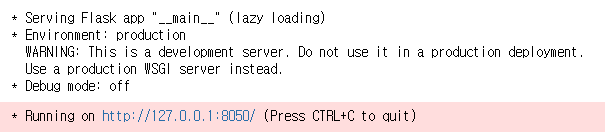

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
all_gu = new_df.GU.unique()

app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1(
        children='용인시 지역별 분기 매출 변화 추이'
    ),
    html.Div(children='''
        지역구별로 옵션을 선택하여 시각화할 수 있습니다.
        
    '''),
    dcc.Checklist(
        id="checklist",
        options=[{"label": x, "value": x} 
                 for x in all_gu],
        value=all_gu[3:],
        labelStyle={'display': 'inline-block'}
    ),
    dcc.Graph(id="line-chart", figure={'layout': {'height': 500, 'width': 600}}),
])



@app.callback(
    Output("line-chart", "figure"), 
    [Input("checklist", "value")])
def update_line_chart(all_gu):
    mask = new_df.GU.isin(all_gu)
    fig = px.line(new_df[mask], 
        x="Q", y="sales", color="JUSO")
    return fig

# app.run_server(debug=False, use_reloader=False)

### 3.3. 정책제안을 위한 지수 생성

    1. 금융 지수: 평균 매출액 / 가중 평균 대출액 * 매출 트랜드 값
    2. 경쟁 지수: 총 상점 수 * 평균 최근린 거리 * Hotspot 여부
    3. 입지 지수: 총 인구 수 * 유동인구 Hot spot * 유동인구

In [ ]:
df_finance = f_dict[16]

# 대출액 평균 금액
loan_dict = {'sme_loan_y_1' : 2500, 'sme_loan_y_2':7500, 'sme_loan_y_3':15000, 'sme_loan_y_4':35000, 'sme_loan_y_5':75000, 'sme_loan_y_6':100000}
df_loan = simple_grid_calc(col_name = 'sme_loan_y', df = df, mode = 'weighted_mean', weight_dict = loan_dict, sum_col = 'ws_cnt')

# 매출액
df_sales = simple_grid_calc(col_name = 'sales_est_amt', df = df, mode = 'mean')
# 매출, 채무 비율 (sales-loan-ratio)
df_finance['SLR'] = (df_sales['sales_est_amt' + '_mean'] * 4)/df_loan['sme_loan_y' + '_weighted_mean']
# 비율이 20 이상인 값은 지움
df_finance['SLR'] = df_finance['SLR'].where(df_finance['SLR'] < 20, np.nan)
# 안전성 지수 = SLR/평균 사업체 나이
df_finance['stability_index'] = df_finance['SLR'] / df_age['found_age' + '_weighted_mean']
cols = ['GN1245T', 'GU', 'EMD', 'geometry']
for c in cols:
    df_finance[c] = df[c]

df_finance = df_finance[['GN1245T', 'GU', 'EMD', 'geometry', 'SLR', 'stability_index']]

df_cur = df_finance.copy()
print(df_cur.columns)

# 매출 트랜드 값(1 or 2)
trend = get_sales_trend(df_16, mode = 'int')
print(df_)

df['금융지수'] = df_finance['SLR'] * trend
# plot_grid_map(df, '금융지수.png', col = '금융지수', title = '금융지수', mode = 'cont_classify', annotation = False, percen = False, colors = 'Blues')


In [ ]:
df['유동인구'] =  df['아침 평균'] + df['점심 평균'] + df['저녁 평균']

# 경쟁지수 산출

# 두가지 구분 방법 제시, HeadTail or FisherJenks
df['ANN'] = mc.HeadTailBreaks(df['평균 nnd 역수']).yb +1
# df['ANN'] = mc.FisherJenks(df['평균 nnd 역수'],k=10).yb +1
df['상점수_cl'] = mc.HeadTailBreaks(df['총 상점 수']).yb +1
# df['상점수_cl'] = mc.FisherJenks(df['총 상점 수'],k=10).yb +1
df['상점 hot_spot'] = df['상점 hot_spot'].where(df['상점 hot_spot'] <= 1, 0)
df['상점 hot_spot'] = df['상점 hot_spot'] + 1
df['경쟁 score'] = (df['ANN'] + df['상점수_cl']) * df['상점 hot_spot']

In [ ]:
wq =  lps.weights.Queen.from_dataframe(df)
c = df['유동인구']
li = esda.Moran_Local(c, wq)
hotspot = 1 * (sig * li.q==1) # H-H

spots = hotspot + 1
df['유동 hot_spot'] = spots

df['총인구 hot_spot'] = df['총인구 hot_spot'].where(df['총인구 hot_spot'] <= 1, 0)
df['총인구 hot_spot'] = df['총인구 hot_spot'] + 1

In [ ]:
# 입지지수 산출

df['총인구수_cl'] = mc.HeadTailBreaks(df['총인구 수']).yb +1
# df['총인구수_cl'] = mc.FisherJenks(df['총인구 수'],k=10).yb +1
df['유동인구_cl'] = mc.HeadTailBreaks(df['유동인구']).yb +1
# df['유동인구_cl'] = mc.FisherJenks(df['유동인구'],k=10).yb +1

df['입지 score'] = (df['총인구수_cl'] * df['총인구 hot_spot']) + (df['유동인구_cl'] * df['유동 hot_spot'])

In [ ]:
df['금융 score'] = df['금융지수'].fillna(0)
df['금융지수'] = mc.FisherJenks(df['금융 score'],k=10).yb +1
# df['금융지수_'] = mc.HeadTailBreaks(df['금융지수_']).yb +1
df['경쟁지수'] = mc.FisherJenks(df['경쟁 score'],k=10).yb +1
# df['경쟁지수'] = mc.HeadTailBreaks(df['경쟁 score']).yb +1
df['입지지수'] = mc.FisherJenks(df['입지 score'],k=10).yb +1
# df['입지지수'] = mc.HeadTailBreaks(df['입지 score']).yb +1

In [ ]:
hr10 = df['금융지수']
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=hr10).plot(column='cl', categorical=True, k= 8, cmap='Blues', linewidth=0.5, ax=ax, edgecolor = 'gainsboro', facecolor = 'black', legend=True)
ax.set_axis_off()
plt.title("금융 지수 grid 맵") # 색이 진할 수록 평균거리가 작음
plt.savefig(os.path.join(result_path, "금융 지수 grid 맵.png"))

hr10 = df['경쟁지수']
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=hr10).plot(column='cl', categorical=True, k= 8, cmap='Reds', linewidth=0.5, ax=ax, edgecolor = 'gainsboro', legend=True)
ax.set_axis_off()
plt.title("경쟁 지수 grid 맵") # 색이 진할 수록 평균거리가 작음
plt.savefig(os.path.join(result_path, "경쟁 지수 grid 맵.png"))

hr10 = df['입지지수']
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=hr10).plot(column='cl', categorical=True, k= 8, cmap='Greens', linewidth=0.5, ax=ax, edgecolor = 'gainsboro', legend=True)
ax.set_axis_off()
plt.title("입지 지수 grid 맵") # 색이 진할 수록 평균거리가 작음
plt.savefig(os.path.join(result_path, "입지 지수 grid 맵.png"))

### 3.4. 지수를 사용한 그리드 별 정책 제안
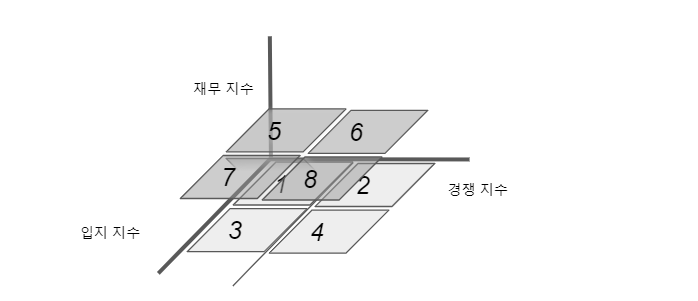

In [ ]:
fig = plt.figure()
fig.set_size_inches((7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.경쟁지수, df.입지지수, df.금융지수, color = 'Blue')
ax.set_zlabel('금융지수', fontsize = 15)
ax.set_xlabel('경쟁지수', fontsize = 15)
ax.set_ylabel('입지지수', fontsize = 15)
plt.title('금융, 경쟁, 입지지수 Scatter plot', fontsize = 15)
fig.show()

#fig.savefig(os.path.join(result_path, '3지수 3D scatterplot.png'))

In [ ]:
plt.scatter(x = df.경쟁지수, y = df.입지지수)
plt.show()

In [ ]:
plt.scatter(x = df.입지지수, y = df.금융지수)
plt.show()

In [ ]:
plt.scatter(x = df.경쟁지수, y = df.금융지수)
plt.show()

In [ ]:
cluster = dict()
for i in range(1, 9):
    if i == 1:
        cluster[i] = df.loc[(df.경쟁지수 < 6) & (df.금융지수 < 6) & (df.입지지수 < 6)]
    elif i == 2:
        cluster[i] = df.loc[(df.경쟁지수 > 5) & (df.금융지수 < 6) & (df.입지지수 < 6)]
    elif i == 3:
        cluster[i] = df.loc[(df.경쟁지수 < 6) & (df.금융지수 < 6) & (df.입지지수 > 5)]
    elif i == 4:
        cluster[i] = df.loc[(df.경쟁지수 > 5) & (df.금융지수 < 6) & (df.입지지수 > 5)]
    elif i == 5:
        cluster[i] = df.loc[(df.경쟁지수 < 6) & (df.금융지수 > 5) & (df.입지지수 < 6)]
    elif i == 6:
        cluster[i] = df.loc[(df.경쟁지수 > 5) & (df.금융지수 > 5) & (df.입지지수 < 6)]
    elif i == 7:
        cluster[i] = df.loc[(df.경쟁지수 < 6) & (df.금융지수 > 5) & (df.입지지수 > 5)]
    elif i == 8:
        cluster[i] = df.loc[(df.경쟁지수 > 5) & (df.금융지수 > 5) & (df.입지지수 > 5)]
        

In [ ]:
cls_list = []
for i, row in df.iterrows():
    if row.경쟁지수 < 6 and row.금융지수 < 6 and row.입지지수 < 6:
        cls_list.append(1)
    elif row.경쟁지수 > 5 and row.금융지수 < 6 and row.입지지수 < 6:
        cls_list.append(2)
    elif row.경쟁지수 < 6 and row.금융지수 < 6 and row.입지지수 > 5:
        cls_list.append(3)
    elif row.경쟁지수 > 5 and row.금융지수 < 6 and row.입지지수 > 5:
        cls_list.append(4)
    elif row.경쟁지수 < 6 and row.금융지수 > 5 and row.입지지수 < 6:
        cls_list.append(5)
    elif row.경쟁지수 > 5 and row.금융지수 > 5 and row.입지지수 < 6:
        cls_list.append(6)
    elif row.경쟁지수 < 6 and row.금융지수 > 5 and row.입지지수 > 5:
        cls_list.append(7)
    elif row.경쟁지수 > 5 and row.금융지수 > 5 and row.입지지수 > 5:
        cls_list.append(8)
    else:
        cls_list.append(np.nan)
        print(i)
df['cls'] = cls_list

In [ ]:
print(df.shape)
sum = 0
for k, v in cluster.items():
    print('key: {} \t shape: {}'.format(k, v.shape))
    sum += v.shape[0]
print(sum)
print(cluster[7])
print(gu)

df_ = assign_address(f_dict, df)

In [ ]:
hr10 = df['cls']
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=hr10).plot(column='cl', categorical=True, k= 8, cmap='Paired', linewidth=0.1, ax=ax,         edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("그리드 별 최종 분류 (금융, 경쟁, 입지지수)") # 색이 진할 수록 평균거리가 작음
plt.savefig(os.path.join(result_path, "3지수 그리드 분류.png"))

## 4. 관심지역 집중 분석

### 4.1. 타지역 SK하이닉스 반도체산업단지와 유사 국가/기업주도 산업단지 인근의 상권업종중분류명 별 소상공인 사업체 개수 및 비율

### 4.2. 용인시 SK하이닉스 반도체산업단지와 기흥 플랫폼시티 인근의 상권업종중분류명 별 소상공인 사업체 비율

***


### 4.1. 타지역 SK하이닉스 반도체산업단지와 유사 국가/기업주도 산업단지 인근의 상권업종중분류명 별 소상공인 사업체 개수 및 비율

In [ ]:
os.chdir(additional_path)

smbz_df_kg = pd.read_csv('소상공인시장진흥공단_상가(상권)정보_경기_202009.csv', sep='|')
smbz_df_cn = pd.read_csv('소상공인시장진흥공단_상가(상권)정보_충남_202009.csv', sep='|')

os.chdir('../')


In [ ]:
# 관심 지역에 해당하는 데이터만 추출

sk_icheon = smbz_df_kg.loc[smbz_df_kg['법정동명'] == '대월면'].copy()
poseung1 = smbz_df_kg.loc[smbz_df_kg['법정동명'] == '안중읍'].copy()
poseung2 = smbz_df_kg.loc[smbz_df_kg['법정동명'] == '포승읍'].copy()
hd_asan = smbz_df_cn.loc[smbz_df_cn['법정동명'] == '인주면'].copy()
poseung = pd.concat([poseung1, poseung2], axis=0)


In [ ]:
# 관심 지역별 POI의 상권업종중분류명 사업체 개수 및 비율 시각화 

sk_icheon_df = sk_icheon['상권업종중분류명'].value_counts().to_frame().reset_index().rename(columns={'index':'category', '상권업종중분류명': 'count'})
poseung_df = poseung['상권업종중분류명'].value_counts().to_frame().reset_index().rename(columns={'index':'category', '상권업종중분류명': 'count'})
hd_asan_df = hd_asan['상권업종중분류명'].value_counts().to_frame().reset_index().rename(columns={'index':'category', '상권업종중분류명': 'count'})

def make_overtime_bargraph(df, x, y, title, color, labels, height, color_scale, width):
        fig =  px.bar(df, x=x, y=y, title=title, color=color, color_continuous_scale=color_scale,
                  labels=labels, height=height, width=width) 
        fig.show()
        #fig.write_image(os.path.join(result_path, title + '.png'))

make_overtime_bargraph(sk_icheon_df, x='category', y='count', title='이천 SK하이닉스 인근 지역의 상권업종중분류명별 소상공인 사업체 개수',
                       color='count', labels={'count': '소상공인 사업체 개수'}, height=700, width=2000, color_scale=px.colors.sequential.Bluered)
make_overtime_bargraph(poseung_df, x='category', y='count', title='포승 공업단지 인근 지역의 상권업종중분류명별 소상공인 사업체 개수',
                       color='count', labels={'count': '소상공인 사업체 개수'}, height=700, width=2000, color_scale=px.colors.sequential.Bluered)
make_overtime_bargraph(hd_asan_df, x='category', y='count', title='아산 현대기아차 공장 인근 지역의 상권업종중분류명별 소상공인 사업체 개수',
                       color='count', labels={'count': '소상공인 사업체 개수'}, height=700, width=2000, color_scale=px.colors.sequential.Bluered)

In [ ]:
def horizontal_stacked_bar1(df_orig, y_s, cut = 0.03, sum_col = None, title = False):
    
    number_of_colors = 78
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    cols = []
    
    for y in y_s:
        cols.append(y)
    names = df_orig['category']
    cols.remove('category')
    df = pd.DataFrame(columns = cols)
    
    for c in cols:
        df[c] = df_orig[c]   

    if cut:
        df = df[df/df.sum() > cut].fillna(0)
        
    x_data = []
    y_data = y_s
    y_data.remove('category')  
    df.index = names
    new_df = pd.DataFrame(columns=cols)
    
    
    for i in range(len(df)):
        #print(df.iloc[i].sum())
        if df.iloc[i].sum() > 1:
            new_df = new_df.append(df.iloc[i])

    for c in new_df.columns:
        x_data.append(new_df[c])

    fig = go.Figure()
    
    for i in range(0, len(x_data[0])):
        cur_color = colors[i]
        fig.add_trace(go.Bar(
            y = y_data,
            x = new_df.iloc[i].tolist(),
            name = new_df.iloc[i].name,
            orientation='h',
            marker=dict(
                color = cur_color,
                line=dict(color='rgb(45, 45, 45)', width=1)
                )
            ))
    fig.update_layout(title='기업 주도 공업단지 지역의 소상공인 상권업종중분류명별 사업체 비율', barmode='stack', 
                      xaxis=dict(
                        showgrid=False,
                        showline=True,
                        showticklabels=False,
                        zeroline=False),
                      paper_bgcolor='rgb(255, 255, 255)',\
                      plot_bgcolor='rgb(255, 255, 255)',
                      margin=dict(l=30, r=40, t=30, b=30),
                      legend=dict(
                          bgcolor='rgb(248, 248, 255)',
                          orientation='v',
                          traceorder='normal',
                          ),
                      width=1500,
                      height=450
                      
                      )
    
    
    annotations = []
    for yd, xd in zip(y_data, x_data):
        space = xd[0]
        for i in range(1, len(xd)):
                # labeling the rest of percentages for each bar (x_axis)
                if xd[i] >30:
                    annotations.append(dict(xref='x', yref='y',
                                            x=space + (xd[i]/2), y=yd,
                                            text=str(int(round(xd[i],2) *0.1)) + '%',
                                            font=dict(family='Arial', size=12,
                                                      color='rgb(67, 67, 67)'),
                                            showarrow=False))
                space += xd[i]
    fig.update_layout(annotations=annotations)
    #fig.write_image(os.path.join(result_path, '기업 주도 공업단지 지역의 소상공인 상권업종중분류명별 사업체 비율.png'))
    fig.show()
    return fig

In [ ]:
ss = sk_icheon_df['category'].unique().tolist()
pp = poseung_df['category'].unique().tolist()
aa = hd_asan_df['category'].unique().tolist()

all_ls = ss + pp + aa
all_ls = list(set(all_ls))

all_df = pd.DataFrame(index=all_ls, columns=['sk', 'poseung', 'hd_asan']).reset_index()
all_df = all_df.fillna(0)
all_df = all_df.rename(columns={'index': 'category'})


for i in range(len(sk_icheon_df)):
    category = sk_icheon_df.iloc[i]['category']
    cnt = sk_icheon_df.iloc[i]['count']
    idx = all_df.loc[all_df['category']==category].index[0]
    all_df.loc[idx, 'sk'] = cnt
    
for i in range(len(poseung_df)):
    category = poseung_df.iloc[i]['category']
    cnt = poseung_df.iloc[i]['count']
    idx = all_df.loc[all_df['category']==category].index[0]
    all_df.loc[idx, 'poseung'] = cnt
    
for i in range(len(hd_asan_df)):
    category = hd_asan_df.iloc[i]['category']
    cnt = hd_asan_df.iloc[i]['count']
    idx = all_df.loc[all_df['category']==category].index[0]
    all_df.loc[idx, 'hd_asan'] = cnt

fig = horizontal_stacked_bar1(all_df, all_df.columns.to_list(), cut = 0.03, sum_col = None, title = 'SK')
#fig.write_image(os.path.join(result_path, '기업 주도 공업단지 지역의 소상공인 상권업종중분류명별 사업체 비율.png'))


### 4.2. 용인시 SK하이닉스 반도체산업단지와 기흥 플랫폼시티 인근의 상권업종중분류명 별 소상공인 사업체 비율


In [ ]:
sk = df_12.loc[df_12['EMD_CD'] == '41461340']
platform = df_12.loc[df_12['EMD_CD'] == '41463101']
platform = platform.append(df_12.loc[df_12['EMD_CD'] == '41463113'])
platform = platform.append(df_12.loc[df_12['EMD_CD'] == '41463118'])
interest_area = pd.concat([sk, platform], axis=0)

area_dict = dict()


for j in tqdm(range(len(interest_area))):
        
        area = [i for i in interest_area.iloc[j]['geometry']]
        shop = pd.DataFrame(data=[], columns=list(df_1.columns))
        
        for idx, row in df_1.iterrows(): 
            
            x_coord = df_1.iloc[idx]['경도']
            y_coord = df_1.iloc[idx]['위도']
            
            if area[0].contains(Point([x_coord, y_coord])):
                shop = shop.append(row)
            
            
        area_dict[interest_area.iloc[j]['EMD_KOR_NM']] = shop
        

cd_kor_list = list(df_2['중분류명'].unique())
  
cnt_df = pd.DataFrame(data=0, columns = cd_kor_list, index=list(interest_area['EMD_KOR_NM']))   
    
for k, v in area_dict.items():
    
     
    for i in range(len(v)):
        cd = v.iloc[i]['중분류코드']
        cd_kor_name = list(df_2.loc[df_2['중분류코드'] == cd]['중분류명'])[0]
        cnt_df.loc[k][cd_kor_name] += 1
   
cnt_df = cnt_df.T

In [ ]:
def horizontal_stacked_bar2(df_orig, y_s, cut = 0.03, sum_col = None, title = False):
    

    number_of_colors = 20
    
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]

    cols = []
    
    for y in y_s:
        cols.append(y)
    names = df_orig['Unnamed: 0']
    cols.remove('Unnamed: 0')
    df = pd.DataFrame(columns = cols)
    
    for c in cols:
        df[c] = df_orig[c]   

    if cut:
        df = df[df/df.sum() > cut].fillna(0)     
    x_data = []
    y_data = y_s
    y_data.remove('Unnamed: 0') 
    
    df.index = names  
    new_df = pd.DataFrame(columns=cols)
    
    for i in range(len(df)):
        if df.iloc[i].sum() > 1:
            new_df = new_df.append(df.iloc[i])
    
    for c in new_df.columns:
        x_data.append(new_df[c])

    fig = go.Figure()
    
    for i in range(0, len(x_data[0])):
        cur_color = colors[i]
        fig.add_trace(go.Bar(
            y = y_data,
            x = new_df.iloc[i].tolist(),
            name = new_df.iloc[i].name,
            orientation='h',
            marker=dict(
                color = cur_color,
                line=dict(color='rgb(45, 45, 45)', width=1)
                )
            ))
    fig.update_layout(title=title, barmode='stack', 
                      xaxis=dict(
                        showgrid=False,
                        showline=True,
                        showticklabels=False,
                        zeroline=False),
                      paper_bgcolor='rgb(255, 255, 255)',\
                      plot_bgcolor='rgb(255, 255, 255)',
                      margin=dict(l=30, r=40, t=30, b=30),
                      legend=dict(
                          bgcolor='rgb(248, 248, 255)',
                          orientation='v',
                          traceorder='normal',
                          ),
                      width=1000,
                      height=700
                      
                      )
    
    
    annotations = []
    for yd, xd in zip(y_data, x_data):
        space = xd[0]
        for i in range(1, len(xd)):
                # labeling the rest of percentages for each bar (x_axis)
                if xd[i] >30:
                    annotations.append(dict(xref='x', yref='y',
                                            x=space + (xd[i]/2), y=yd,
                                            text=str(int(round(xd[i],2) *0.1)) + '%',
                                            font=dict(family='Arial', size=12,
                                                      color='rgb(67, 67, 67)'),
                                            showarrow=False))
                space += xd[i]
    fig.update_layout(annotations=annotations)
    return fig

In [ ]:
cnt_df.to_csv(os.path.join(pre_processed_path, 'cnt_df.csv'))
cnt_df = pd.read_csv(os.path.join(pre_processed_path, 'cnt_df.csv'))

fig = horizontal_stacked_bar2(cnt_df, cnt_df.columns.to_list(), cut = 0.03, sum_col = None, title = 'SK하이닉스 반도체산업단지와 기흥 플랫폼시티 인근 사업체 비율')
fig.show()
#fig.write_image(os.path.join(result_path, 'SK 하이닉스 반도체산업단지와 기흥 플랫폼시티 인근 사업체 비율.png'))